In [1]:
"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for channel flow (Poisseuille) on the unit square using the
Incremental Pressure Correction Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
								 div(u) = 0
"""

from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
T = 10.0           # final time
num_steps = 50    # number of time steps
dt = T / num_steps # time step size
mu = 1             # kinematic viscosity
rho = 1            # density

To create a Mesh, either use one of the built-in meshes https://fenicsproject.org/docs/dolfin/1.4.0/python/demo/documented/built-in_meshes/python/documentation.html or create a custom one. 

Notice that the class PolygonalMeshGenerator has been deprecated so it's no longer available. Instead, we need to call generate_mesh on a custom domain. Custom domains are generated by combining through union, intersection or difference elementary shapes. Custom meshes require the package mshr https://bitbucket.org/benjamik/mshr/src/master/ , which comes if FEniCS is installed system-wide (i.e. through apt, not through Anaconda). Elementary shapes are, which are dolfin.Point, Rectangle, Circle, Ellipse, Polygon: https://bitbucket.org/benjamik/mshr/wiki/browse/API

The two next cells are **alternatives** implementing a built-in mesh over a unit square or custom one.

In [53]:
# Create mesh
mesh = UnitSquareMesh(16, 16)

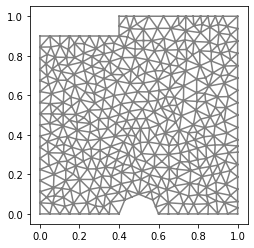

In [38]:
domain = Rectangle(Point(0., 0.), Point(1., 1.)) - \
         Circle(dolfin.Point(0.5, 0.0), 0.1) - \
         Rectangle(dolfin.Point(0.0, 0.9), dolfin.Point(0.4, 1.0)) 

mesh = generate_mesh(domain, 16, "cgal")
plot(mesh)

In [54]:
# Define function spaces
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

Obs. that "Custom expressions defined in Python are no longer subclasses of Expression (as documented in https://fenicsproject.org/docs/dolfin/1.6.0/python/programmers-reference/functions/expression/Expression.html), but, instead, of a separate class, UserExpression". That's why class `class MyExpression(Expression)` must be
`class MyExpression(UserExpression)` instead.

# Define boundaries
left  = 'near(x[0], 0)'
right = 'near(x[0], 1)'
above = 'near(x[1], 1)'
below = 'near(x[1], 0)'

class MyExpression0(UserExpression):
    def eval(self, value, x):
        value[0] = 0
        value[1] = 0
        
        if(x[1] > 0 and x[1] < 1/4):
            value[0] = -exp(-(x[1]-1/8)*(x[1]-1/8))
            value[1] = 0
        
    def value_shape(self): #no idea what this does!! 
        return (2,)
    
#Expression('-sin(2*pi*x[1])', degree=2)
f0 = MyExpression0()

# Define boundary conditions
bcu_right = DirichletBC(V, f0, right)
bcu_left  = DirichletBC(V, Constant((0.0, 0.0)), left)
bcu_above = DirichletBC(V, Constant((0.0, 0.0)), above)
bcu_below  = DirichletBC(V, Constant((0.0, 0.0)), below)

bcp_above = DirichletBC(Q, Constant(0), above)
bcp_below = DirichletBC(Q, Constant(0), below)
#bcp_outflow = DirichletBC(Q, Expression('sin(2*pi*x[1])', degree=2), outflow)

#Group them together for later usage
bcu = [bcu_right, bcu_left, bcu_above, bcu_below]
bcp = [bcp_above, bcp_below]

In [55]:
# Define boundaries
left  = 'near(x[0], 0)'
right_up = 'near(x[0], 1) && x[1] > 1/2'
right_low = 'near(x[0], 1) && x[1] < 1/2'
above = 'near(x[1], 1)'
below = 'near(x[1], 0)'

#-exp(-(x[1]-6/8)*(x[1]-6/8))

# Define boundary conditions
bcu_right_up = DirichletBC(V, Expression(('-sin(2*pi*x[1])', 0), degree=2), right_up)
bcu_right_low = DirichletBC(V, Expression(('-sin(2*pi*x[1])', 0), degree=2), right_low)
bcu_left  = DirichletBC(V, Constant((0.0, 0.0)), left)
bcu_above = DirichletBC(V, Constant((0.0, 0.0)), above)
bcu_below  = DirichletBC(V, Constant((0.0, 0.0)), below)

bcp_above = DirichletBC(Q, Constant(0), 'near(x[0], 1) && near(x[1], 1)')
#bcp_below = DirichletBC(Q, Constant(0), below)

#Group them together for later usage
bcu = [bcu_right_up, bcu_right_low, bcu_left, bcu_above, bcu_below]
bcp = [bcp_above]

In [56]:
# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
g   = 9.81
f   = Constant((0, -g))
k   = Constant(dt)
mu  = Constant(mu)
rho = Constant(rho)

In [57]:
# Define strain-rate tensor
def epsilon(u):
	return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
	return 2*mu*epsilon(u) - p*Identity(len(u))

In [58]:
# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx + \
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
     + inner(sigma(U, p_n), epsilon(v))*dx \
     + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
     - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

In [59]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None]

In [60]:
# Time-stepping
t = 0
for n in range(num_steps):
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    # Compute error
    u_e = Expression(('4*x[1]*(1.0 - x[1])', '0'), degree=2)
    u_e = interpolate(u_e, V)
    error = np.abs(u_e.vector().get_local() - u_.vector().get_local()).max()
    #print('t = %.2f: error = %.3g' % (t, error))
    #print('max u:', u_.vector().get_local().max())

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)    

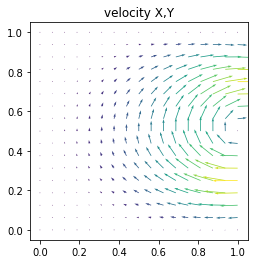

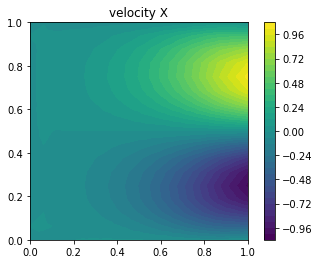

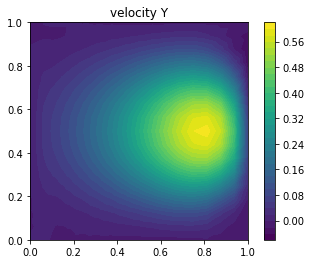

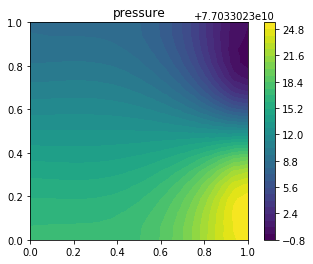

In [61]:
# Plot solution
#fig = plt.figure(figsize=(80, 60))

fig = plot(u_, title='velocity X,Y')
plt.show()

fig = plot(u_[0], title='velocity X')
plt.colorbar(fig)
plt.show()

fig = plot(u_[1], title='velocity Y')
plt.colorbar(fig)
plt.show()

fig = plot(p_, title='pressure')
plt.colorbar(fig)
plt.show()


[[ 0.          0.        ]
 [ 0.0625      0.        ]
 [ 0.          0.0625    ]
 [ 0.125       0.        ]
 [ 0.1875      0.        ]
 [ 0.25        0.        ]
 [ 0.3125      0.        ]
 [ 0.375       0.        ]
 [ 0.4375      0.        ]
 [ 0.5         0.        ]
 [ 0.5625      0.        ]
 [ 0.625       0.        ]
 [ 0.6875      0.        ]
 [ 0.75        0.        ]
 [ 0.8125      0.        ]
 [ 0.875       0.        ]
 [ 0.9375      0.        ]
 [-0.0220238   0.        ]
 [-0.41058672  0.0625    ]
 [ 0.          0.125     ]
 [-0.73981149  0.125     ]
 [ 0.          0.1875    ]
 [-0.96245601  0.1875    ]
 [ 0.          0.25      ]
 [-1.04211715  0.25      ]
 [ 0.          0.3125    ]
 [-0.96530646  0.3125    ]
 [ 0.          0.375     ]
 [-0.74304911  0.375     ]
 [ 0.          0.4375    ]
 [-0.40890136  0.4375    ]
 [ 0.          0.5       ]
 [-0.01361234  0.5       ]
 [ 0.          0.5625    ]
 [ 0.38251497  0.5625    ]
 [ 0.          0.625     ]
 [ 0.71906715  0.625     ]
 

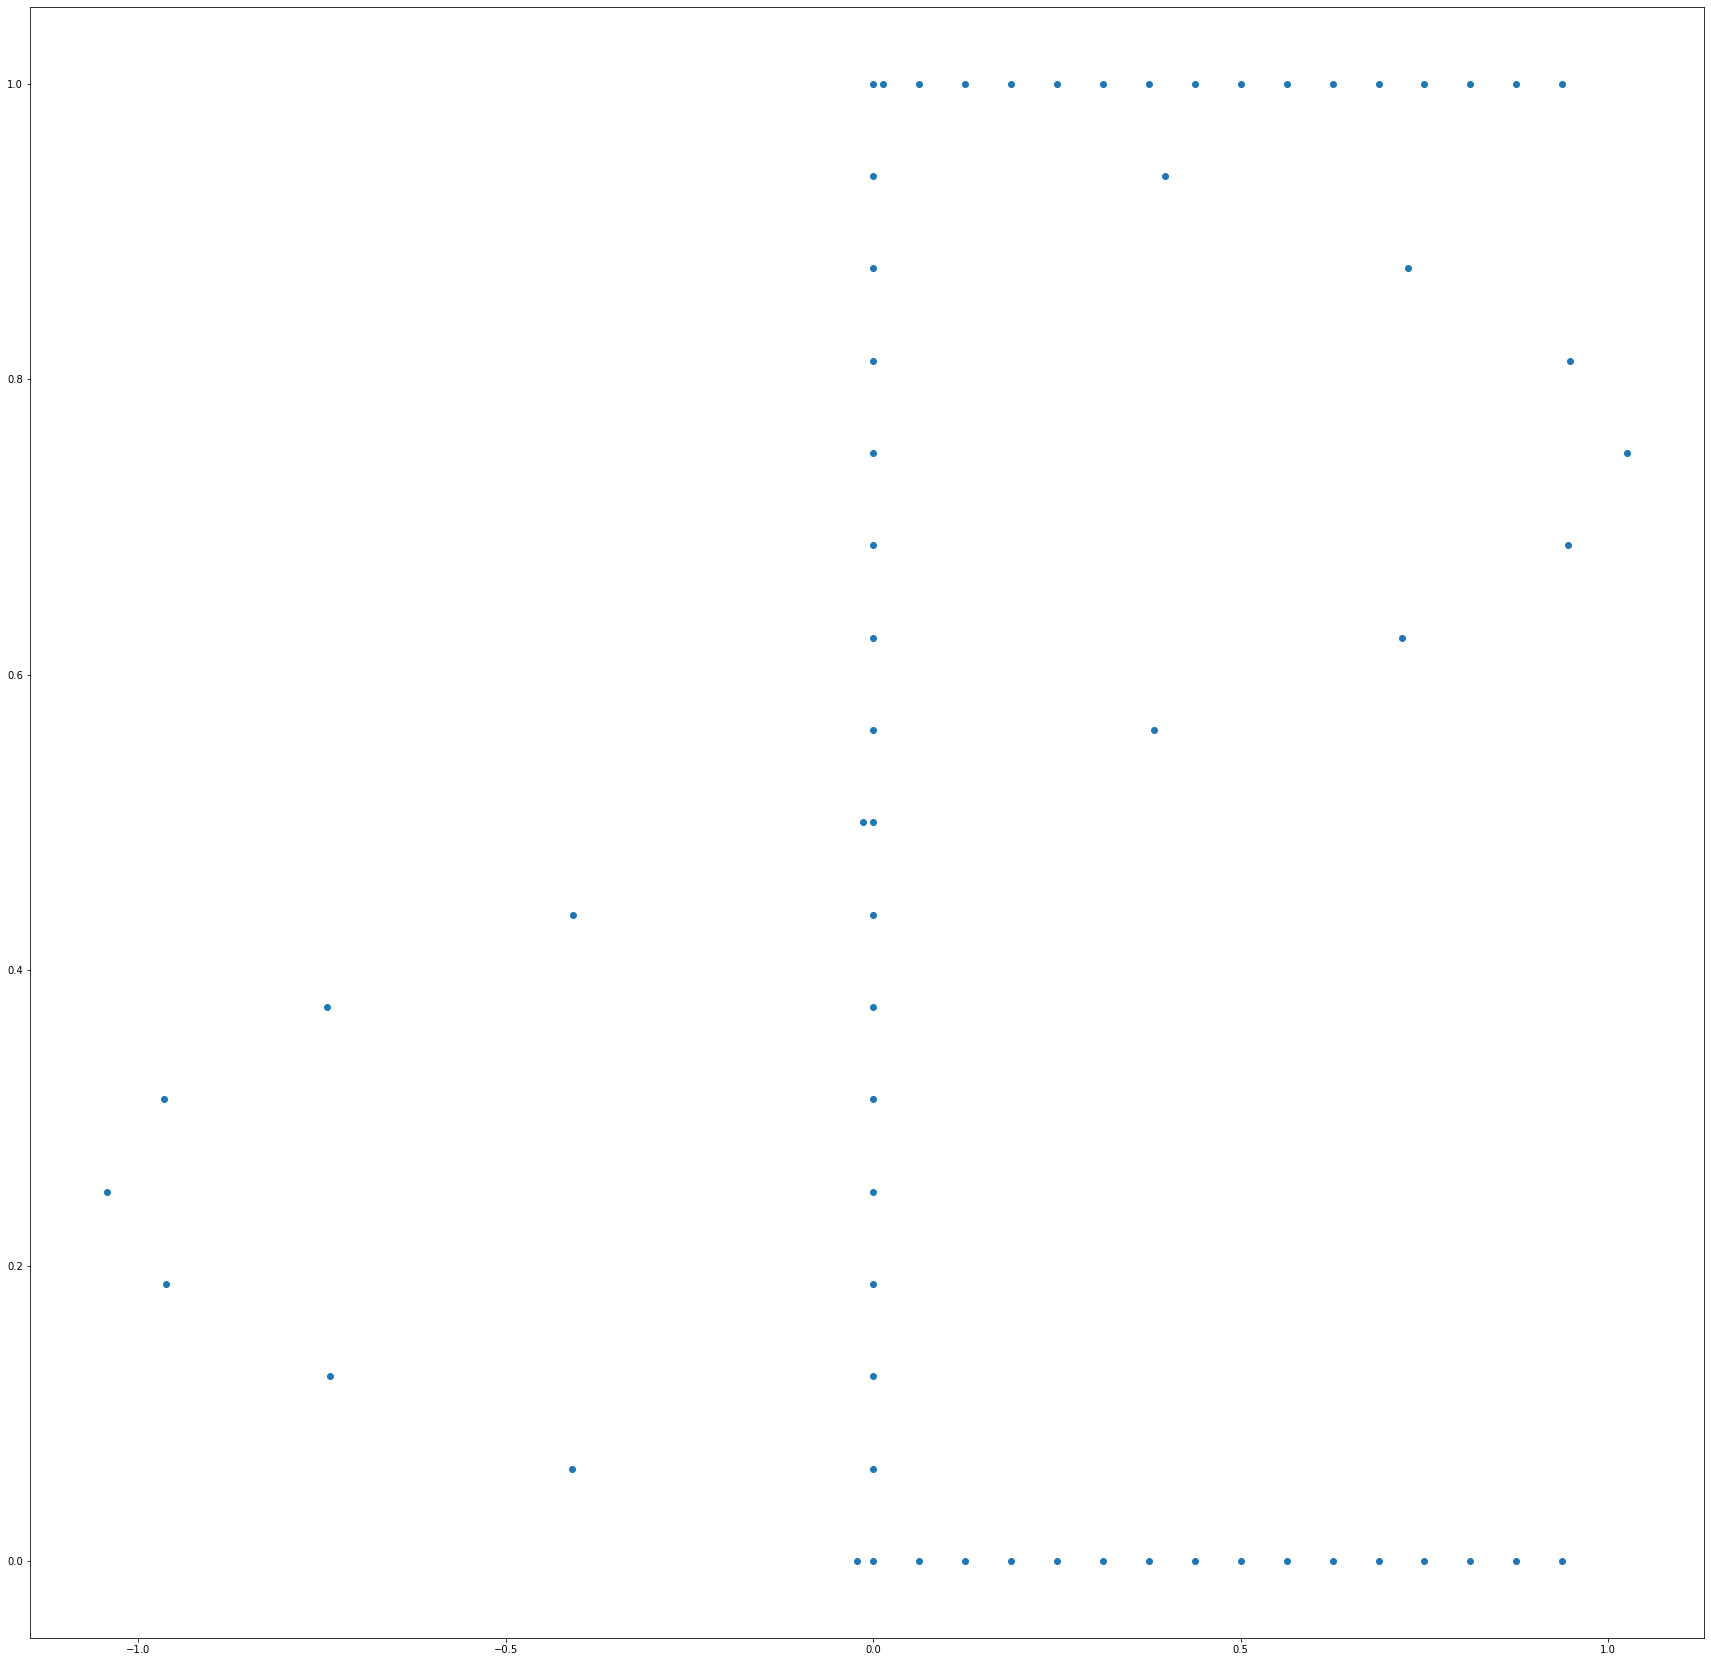

In [118]:
_u_1, _u_2 = u_.split(True)

bmesh = BoundaryMesh(mesh, "exterior", True)   ########
boundarycoords=bmesh.coordinates()

rightboundary=[]
xvelrightboundary=[]
BC = np.empty(shape=(len(boundarycoords), 2))
for i in range(len(boundarycoords)):
    
    if boundarycoords[i][0]==1:
        BC[i][1] = boundarycoords[i][1]
        BC[i][0] = _u_1(boundarycoords[i])
        #rightboundary.append(boundarycoords[i][1])
        xvelrightboundary.append(_u_1(point))
        #BC = np.append(BC, [_u_1(point), point[1]])
    else:
        BC[i][0] = boundarycoords[i][0]
        BC[i][1] = boundarycoords[i][1]
        #BC = np.append(BC, [point[0], point[1]])


print(BC)

        
#fig5=plt.figure(figsize=(30, 30))
#plt.plot(rightboundary,xvelrightboundary,'*')

fig6=plt.figure(figsize=(30,30))
plt.scatter(BC[:,0], BC[:,1])
plt.show()

#plt.scatter(boundarycoords[:,0], boundarycoords[:,1])


In [75]:
#Why not equal??
print(u_.sub(0))
print(_u_1)
print(_u_1 == u_.sub(0))
print(boundarycoords[:,0])

f_10957-0
f_10957-0
False
[0.     0.0625 0.     0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5
 0.5625 0.625  0.6875 0.75   0.8125 0.875  0.9375 1.     1.     0.
 1.     0.     1.     0.     1.     0.     1.     0.     1.     0.
 1.     0.     1.     0.     1.     0.     1.     0.     1.     0.
 1.     0.     1.     0.     1.     0.     1.     0.     1.     0.0625
 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625 0.625  0.6875
 0.75   0.8125 0.875  0.9375]


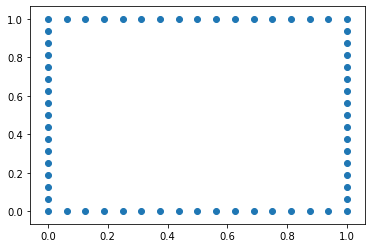

In [78]:
plt.scatter(boundarycoords[:,0], boundarycoords[:,1])

In [95]:
arr = np.array([[1,1], [2,2]])
print(type(boundarycoords))
for i in range(len(arr)):
    print(i, arr[i])
    arr[i] = [3*arr[i][0], 3*arr[i][1]]

print(arr)

<class 'numpy.ndarray'>
0 [1 1]
1 [2 2]
[[3 3]
 [6 6]]
